# Tasks

Build gates in Fluxonium via qutip exclusively

1. Approx fluxonium as a two level system as before

2. Define H0, drive (sx term), define initial state, tell qutip mesolve to return full solution (list of the wavefunctions at times defined bu times array (use qoptions)), evolve system using mesolve

Everything in lab frame 

3. Obtain the solution and then plot the population of state 0 and 1

4. Switch to multiple level fluxonium instead of the two level idea

In [166]:
import qutip as qt
import scqubits as scq
import numpy as np

## Approximate 2 level fluxonium

In [167]:
fluxonium = scq.Fluxonium(EJ = 8.9,
                               EC = 2.5,
                               EL = 0.5,
                               flux = 0.33,
                               cutoff = 110)

fluxonium

Fluxonium(**{'EJ': 8.9, 'EC': 2.5, 'EL': 0.5, 'flux': 0.33, 'cutoff': 110, 'truncated_dim': 6, 'id_str': 'Fluxonium_20', 'evals_method': None, 'evals_method_options': None, 'esys_method': None, 'esys_method_options': None})

In [168]:
Hamiltonian = qt.Qobj(fluxonium.hamiltonian())

Hamiltonian

Quantum object: dims=[[110], [110]], shape=(110, 110), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 2.46327407e+00  2.85342367e+00 -1.97251437e+00 ... -8.14776918e-60
   7.65836046e-61  2.44237346e-61]
 [ 2.85342367e+00  2.83599516e+00 -2.34509884e+00 ... -2.61555195e-58
  -8.21241883e-59  7.99556305e-60]
 [-1.97251437e+00 -2.34509884e+00  7.61939246e+00 ...  1.94492951e-56
  -1.86354530e-57 -6.06447257e-58]
 ...
 [-8.14776918e-60 -2.61555195e-58  1.94492951e-56 ...  3.39551088e+02
  -4.40780822e-02 -1.37618811e-01]
 [ 7.65836046e-61 -8.21241883e-59 -1.86354530e-57 ... -4.40780822e-02
   3.42922702e+02 -4.84399444e-03]
 [ 2.44237346e-61  7.99556305e-60 -6.06447257e-58 ... -1.37618811e-01
  -4.84399444e-03  3.46221965e+02]]

In [169]:
fluxonium.eigenvals()

array([-1.72737703,  1.343799  ,  8.49448413, 12.13437429, 13.34329487,
       17.70414565])

## Definitions

### H0

In [170]:
evals, evecs = fluxonium.eigensys(evals_count=2)

omega_01 = evals[1] - evals[0]

omega_01

H_0 = 0.5 * omega_01 * qt.sigmaz()

H_0

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 1.53558801  0.        ]
 [ 0.         -1.53558801]]

### Drive term

In [171]:
A = 0.1
omega_d = omega_01

H = [H_0, [A * qt.sigmax(), 'cos(wd * t)']]
args = {'wd': omega_d}

### Initial State

In [172]:
psi0 = qt.basis(2, 0)

psi0

Quantum object: dims=[[2], [1]], shape=(2, 1), type='ket', dtype=Dense
Qobj data =
[[1.]
 [0.]]

### Mesolve operations

In [173]:
times = np.linspace(0, 100, 1000)

proj_0 = qt.basis(2, 0) * qt.basis(2, 0).dag()

proj_1 = qt.basis(2, 1) * qt.basis(2, 1).dag()

proj_0

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=True
Qobj data =
[[1. 0.]
 [0. 0.]]

In [174]:
proj_1

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0. 0.]
 [0. 1.]]

In [175]:
result = qt.mesolve(
    H, psi0, times, [],
    [proj_0, proj_1],
    args=args
)


 c:\Users\Owner\anaconda3\Lib\site-packages\qutip\solver\solver_base.py: 576

## Plot population of 0 and 1

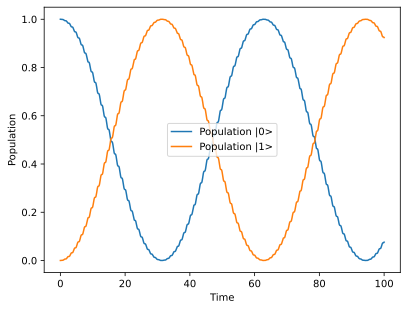

In [176]:
import matplotlib.pyplot as plt

plt.plot(times, result.expect[0], label='Population |0>')
plt.plot(times, result.expect[1], label='Population |1>')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.show()

In [178]:
from qutip import Options

options = Options(store_states=True, atol=1e-12) #change tolerance as needed

result = qt.mesolve(
    H, psi0, times, [],
    [proj_0, proj_1],
    args=args, options=options
)

states = result.states  # List of Qobj states at each time step

states

[Quantum object: dims=[[2], [1]], shape=(2, 1), type='ket', dtype=Dense
 Qobj data =
 [[1.]
  [0.]],
 Quantum object: dims=[[2], [1]], shape=(2, 1), type='ket', dtype=Dense
 Qobj data =
 [[9.88161124e-01-0.15310543j]
  [1.20131882e-05-0.00981429j]],
 Quantum object: dims=[[2], [1]], shape=(2, 1), type='ket', dtype=Dense
 Qobj data =
 [[9.52942317e-01-0.30258719j]
  [1.87268926e-04-0.01849044j]],
 Quantum object: dims=[[2], [1]], shape=(2, 1), type='ket', dtype=Dense
 Qobj data =
 [[0.89522212-0.44491387j]
  [0.00090762-0.02506363j]],
 Quantum object: dims=[[2], [1]], shape=(2, 1), type='ket', dtype=Dense
 Qobj data =
 [[0.81641915-0.57673075j]
  [0.00269789-0.02888156j]],
 Quantum object: dims=[[2], [1]], shape=(2, 1), type='ket', dtype=Dense
 Qobj data =
 [[0.71843611-0.69493271j]
  [0.00608398-0.02968287j]],
 Quantum object: dims=[[2], [1]], shape=(2, 1), type='ket', dtype=Dense
 Qobj data =
 [[0.60360003-0.79672726j]
  [0.0114394 -0.02760105j]],
 Quantum object: dims=[[2], [1]], sha

# Part 2 - Addition of Gamma

In [ ]:
gamma = 0.005 * omega_01  #example value for gamma (small)

c_ops = [ (gamma ** 0.5) * qt.sigmam() ]

In [181]:
result_gamma = qt.mesolve(
    H, psi0, times, c_ops,
    [proj_0, proj_1],
    args=args, options=options
)

result_gamma

 c:\Users\Owner\anaconda3\Lib\site-packages\qutip\solver\solver_base.py: 576

<Result
  Solver: sesolve
  Solver stats:
    method: 'scipy zvode adams'
    init time: 0.0
    preparation time: 0.0
    run time: 0.029994726181030273
    solver: 'Schrodinger Evolution'
  Time interval: [0.0, 100.0] (1000 steps)
  Number of e_ops: 2
  States saved.
>

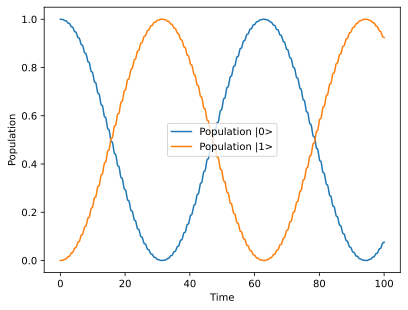

In [182]:
import matplotlib.pyplot as plt

plt.plot(times, result_gamma.expect[0], label='Population |0>')
plt.plot(times, result_gamma.expect[1], label='Population |1>')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.show()

# Switch to multi-level system instead of two